## Triple Stratified KFold CV with TFRecords
https://www.kaggle.com/haqishen/1st-place-soluiton-code-small-ver?select=submission.csv

https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-TFRECORDS

## 一、載入相關套件

In [1]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# 資料處理套件
import os
import cv2
import csv
import random
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import matplotlib.pyplot as plt # plt 用於顯示圖片
import seaborn as sns
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 設定顯示中文字體
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['font.family'] = 'AR PL UMing CN'

In [4]:
# tensorflow深度學習模組套件
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf, re, math
import tensorflow.keras.backend as K

# 查看tensorflow版本
print(tf.__version__)

# 查看圖像通道位置
print(K.image_data_format())

2.2.0
channels_last


## 二、參數設定

In [5]:
'''執行環境'''

# 是否為本機
LOCAL = False

# 是GPU還是TPU
if LOCAL:
    DEVICE = "GPU"
else:
    DEVICE = "TPU"

if not LOCAL:
    from kaggle_datasets import KaggleDatasets

# 是否要裁切圖片
CROPPED_IMGS = False

# 是否要轉成TFRECORDS
CONVERT_TFRECORDS = False

# 是否要轉換圖像RGB2BGR
CONVERT_RGB2BGR = False


'''圖片處理'''

# 圖片比例 IPIXEL*IPIXEL
IPIXEL = 512

# 圖片格式
IMAGE_FORMAT = ".jpg"

# 解壓縮後資料夾名稱
ROOT_ORIGINAL_PATH="C1-P2_Train_Dev/"
TRAIN_ORIGINAL_PATH="C1-P2_Train_Dev/Train/"
TEST_ORIGINAL_PATH="C1-P2_Train_Dev/Test/"

# 建立裁切時需要的資料夾名稱
TRAIN_CROPPED_PATH = "Train/"
TEST_CROPPED_PATH = "Test/"

# 建立TFRECORDS時需要的資料夾名稱
TRAIN_TFRECORDS_PATH = "TrainTFR/"
TEST_TFRECORDS_PATH = "TestTFR/"

# 建立TFRECORDS圖片時需要的資料夾
if LOCAL:
    if not os.path.isdir(TRAIN_TFRECORDS_PATH):
        os.mkdir(TRAIN_TFRECORDSS_PATH)

    if not os.path.isdir(TEST_TFRECORDS_PATH):
        os.mkdir(TEST_TFRECORDSS_PATH)

# 設定TFRECORDS跟images數量，取得tfrsize有多大
TFRECORDS = 15
TRAIN_IMGS = 45000 
# TRAIN_IMGS = 52000 #暫時
TEST_IMGS = 7000
TRAIN_TFRSIZE = math.ceil(TRAIN_IMGS / TFRECORDS)
TEST_TFRSIZE = math.ceil(TEST_IMGS / TFRECORDS)


''''模型參數設定'''

# 分類項目
CLASSES = ['A','B','C']

# 預訓練權重為imagenet還是noisy-student
WEIGHTS_IMAGENET = False

# 不同的種子會產生不同的三重分層kfold分裂
SEED = 42

# 最好設置為3、5或15，但可以是2到15之間的任何數字
FOLDS = 5

# 這些是每折使用的圖像尺寸
IMAGE_SIZE = [IPIXEL,IPIXEL]

#how many training samples we want going to TPUs
BATCH_SIZE = 8

# 定義aug batch size
AUG_BATCH = BATCH_SIZE

# 每次折疊都會保存並使用最佳時期模型，因此如果時期太大，則無法
EPOCHS = [12]*FOLDS

# 數字0表示EfficientNetB0，數字1表示EfficientNetB1，依此類推
# EFF_NETS = [6,6,6,6,6]
EFF_NETS = [1,1,1,1,1]

# 每折應為1 / FOLDS。這是合計折疊以預測測試集時的重量。如果您想要一個奇怪的合奏，可以使用不同的權重
WGTS = [1/FOLDS]*FOLDS

# 測試時間增加。每個測試圖像都會隨機增加並預測TTA時間，並使用平均預測。驗證期間，TTA也適用於OOF
TTA = 8

# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1

# 是否呈現訓練過程圖示
DISPLAY_PLOT = True


'''資料擴增參數設定'''

ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [6]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## 三、讀取資料

In [7]:
if not LOCAL:
    !ls /kaggle/input

mango-tfrecords-512x512


In [8]:
if LOCAL:
    TRAIN_GCS_PATH = TRAIN_TFRECORDS_PATH
    TEST_GCS_PATH = TEST_TFRECORDS_PATH
    files_train = np.sort(np.array(tf.io.gfile.glob(TRAIN_GCS_PATH + 'train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(TEST_GCS_PATH + 'test*.tfrec')))
else:
    GCS_PATH = KaggleDatasets().get_gcs_path('mango-tfrecords-%ix%i'%(IPIXEL,IPIXEL))
    files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
    files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

In [9]:
files_train

array(['gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train00-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train01-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train02-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train03-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train04-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train05-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train06-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train07-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train08-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/train09-3000.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f

In [10]:
files_test

array(['gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test00-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test01-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test02-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test03-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test04-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test05-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test06-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test07-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test08-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee54801c/test09-467.tfrec',
       'gs://kds-4a6b050cb2c99d19003863ff32ee40e4f3ee96d5ef2a5b58ee548

In [11]:
if LOCAL:
    print("Reading data...")

    # 讀取訓練資料集CSV檔
    train_data = pd.read_csv(ROOT_ORIGINAL_PATH+"train.csv",encoding="utf8")

    # 讀取開發資料集CSV檔
    dev_data = pd.read_csv(ROOT_ORIGINAL_PATH+"dev.csv",encoding="utf8")

    # 讀取測試資料集CSV檔
    # test_data = pd.read_csv(ROOT_ORIGINAL_PATH+"test_example.csv",encoding="utf8") # 暫時
    test_data = dev_data 

    print("Reading data completed")

In [12]:
# 顯示訓練資料集CSV檔
if LOCAL:
    train_data.head()

In [13]:
if LOCAL:
    print("Shape of train_data :", train_data.shape)

In [14]:
# 顯示開發資料集CSV檔
if LOCAL:
    print(dev_data.head())

In [15]:
if LOCAL:
    print("Shape of dev_data :", dev_data.shape)

In [16]:
# 顯示測試資料集CSV檔
if LOCAL:
    print(test_data.head())

In [17]:
if LOCAL:
    print("Shape of test_data :", test_data.shape)

## 四、檢查CSV檔缺失值

In [18]:
if LOCAL:
    total = train_data.isnull().sum().sort_values(ascending = False)
    percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
    missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_train_data.head()

In [19]:
if LOCAL:
    sns.countplot(train_data["grade"], hue = train_data["grade"])

In [20]:
if LOCAL:
    train_sector = train_data.groupby("grade")
    print(train_sector.size())

In [21]:
if LOCAL:
    total = dev_data.isnull().sum().sort_values(ascending = False)
    percent = (dev_data.isnull().sum()/dev_data.isnull().count()*100).sort_values(ascending = False)
    missing_dev_data  = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    missing_dev_data.head()

In [22]:
if LOCAL:
    sns.countplot(dev_data["grade"], hue = dev_data["grade"])

In [23]:
if LOCAL:
    dev_sector = dev_data.groupby("grade")
    print(dev_sector.size())

## 五、裁切芒果圖片

## 1. Images 512x512 TrainDataSet : 52000

In [24]:
# 暫時
# if CROPPED_IMGS:
#     # 建立裁切圖片時需要的資料夾
#     if not os.path.isdir(TRAIN_CROPPED_PATH):
#         os.mkdir(TRAIN_CROPPED_PATH)

#     print("Processing")
#     train_data = pd.concat((train_data, dev_data,  ), axis = 'index')  
#     for index,row in  train_data.iterrows():
#         filepath=TRAIN_ORIGINAL_PATH+row['image_id'] 
#         img = cv2.imdecode(np.fromfile(filepath),cv2.IMREAD_COLOR)

#         # 裁切區域的 x 與 y 座標（左上角）
#         x = row['pos_x']
#         y = row['pos_y']

#         # 裁切區域的長度與寬度
#         w = row['width']
#         h = row['height']

#         if x<0:
#             x = 0
#             w =  w + abs(x)

#         if y<0:
#             y = 0
#             h =  h + abs(y)

#         # 裁切圖片
#         img = img[y:y+h, x:x+w]

#         # 因為圖片比例大小不同，所以把圖片的比例壓縮
#         img = cv2.resize(img,(IPIXEL,IPIXEL),interpolation=cv2.INTER_LINEAR)

#         #寫入圖片到資料夾
#         cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tofile(TRAIN_CROPPED_PATH+"/"+row['image_id'])
#     print("Done")

## 2. Images 512x512 TrainDataSet : 45000 TestDataSet : 7000

In [25]:
if CROPPED_IMGS:
    # 建立裁切圖片時需要的資料夾
    if not os.path.isdir(TRAIN_CROPPED_PATH):
        os.mkdir(TRAIN_CROPPED_PATH)

    if not os.path.isdir(TEST_CROPPED_PATH):
        os.mkdir(TEST_CROPPED_PATH)   

    print("Processing")

    for index,row in  train_data.iterrows():
        filepath=TRAIN_ORIGINAL_PATH+row['image_id'] 
        img = cv2.imdecode(np.fromfile(filepath),cv2.IMREAD_COLOR)

        # 裁切區域的 x 與 y 座標（左上角）
        x = row['pos_x']
        y = row['pos_y']

        # 裁切區域的長度與寬度
        w = row['width']
        h = row['height']

        if x<0:
            x = 0
            w =  w + abs(x)

        if y<0:
            y = 0
            h =  h + abs(y)

        # 裁切圖片
        img = img[y:y+h, x:x+w]

        # 因為圖片比例大小不同，所以把圖片的比例壓縮
        img = cv2.resize(img,(IPIXEL,IPIXEL),interpolation=cv2.INTER_LINEAR)

        #寫入圖片到資料夾
        cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tofile(TRAIN_CROPPED_PATH+"/"+row['image_id'])

    for index,row in  test_data.iterrows():
        filepath=TEST_ORIGINAL_PATH+row['image_id'] 
        img = cv2.imdecode(np.fromfile(filepath),cv2.IMREAD_COLOR)

        # 裁切區域的 x 與 y 座標（左上角）
        x = row['pos_x']
        y = row['pos_y']

        # 裁切區域的長度與寬度
        w = row['width']
        h = row['height']

        if x<0:
            x = 0
            w =  w + abs(x)

        if y<0:
            y = 0
            h =  h + abs(y)

        # 裁切圖片
        img = img[y:y+h, x:x+w]

        # 因為圖片比例大小不同，所以把圖片的比例壓縮
        img = cv2.resize(img,(IPIXEL,IPIXEL),interpolation=cv2.INTER_LINEAR)

        #寫入圖片到資料夾
        cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tofile(TEST_CROPPED_PATH+"/"+row['image_id'])

    print("Done")

## 六、圖片轉成 TFRECORDS
https://www.kaggle.com/cdeotte/how-to-create-TFRECORDS

In [26]:
if CONVERT_TFRECORDS:
    def _bytes_feature(value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
    def _float_feature(value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

## Write TFRECORDS - Train

In [27]:
if CONVERT_TFRECORDS:
    def train_serialize_example(feature0, feature1, feature2):
        """
        Creates a tf.Example message ready to be written to a file.
        """
        # Create a dictionary mapping the feature name to the tf.Example-compatible
        # data type.
        feature = {
            'image': _bytes_feature(feature0),
            'image_name': _bytes_feature(feature1),
            'label': _int64_feature(feature2)
        }
        # Create a Features message using tf.train.Example.

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

## Write TFRECORDS - Test

In [28]:
if CONVERT_TFRECORDS:
    def test_serialize_example(feature0, feature1):
        """
        Creates a tf.Example message ready to be written to a file.
        """
        # Create a dictionary mapping the feature name to the tf.Example-compatible
        # data type.
        feature = {
            'image': _bytes_feature(feature0),
            'image_name': _bytes_feature(feature1),
        }
        # Create a Features message using tf.train.Example.

        example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

## 1. TFRECORDS 512x512 TrainDataSet : 52000

In [29]:
# # 暫時
# if CONVERT_TFRECORDS:
#     # TRAIN_CROPPED_PATH to images
#     train_imgs = os.listdir(TRAIN_CROPPED_PATH);
#     print('There are %i train images'%(len(train_imgs)))

In [30]:
# # 暫時
# if CONVERT_TFRECORDS:
#     # load train meta data
#     train_data = pd.concat((train_data, dev_data,  ), axis = 'index')
#     train_data = train_data.drop(columns=["pos_x", "pos_y","width","height"])
#     train_data["image_id"] = train_data["image_id"].str.slice(stop=5)
#     train_data.rename({'image_id':'image_name','grade':'label'},axis=1,inplace=True)
#     print(train_data.shape)
#     print(train_data.head())

## Label Encode Meta Data

In [31]:
# # 暫時
# if CONVERT_TFRECORDS:
#     # LABEL ENCODE ALL STRINGS
#     cats = ["label"] 
#     for c in cats:
#         train_data[c],mp = train_data[c].factorize()
#         print(train_data[c])
#         print("=========")
#         print(mp)

In [32]:
# # 暫時
# if CONVERT_TFRECORDS:
# # 建立TFRECORDS圖片時需要的資料夾
#     if not os.path.isdir(TRAIN_TFRECORDS_PATH):
#         os.mkdir(TRAIN_TFRECORDS_PATH)

#     ct = len(train_imgs)//TRAIN_TFRSIZE + int(len(train_imgs)%TRAIN_TFRSIZE!=0)    
#     for j in range(ct):
#         print('Writing TFRECORDS %i of %i...'%(j,ct))
#         ct2 = min(TRAIN_TFRSIZE,len(train_imgs)-j*TRAIN_TFRSIZE)
#         with tf.io.TFRECORDSWriter(TRAIN_TFRECORDS_PATH+'train%.2i-%i.tfrec'%(j,ct2)) as writer:
#             for k in range(ct2):
#                 img = cv2.imread(TRAIN_CROPPED_PATH+train_imgs[TRAIN_TFRSIZE*j+k])
#                 if CONVERT_RGB2BGR:
#                     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
#                 img = cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
#                 name = train_imgs[TRAIN_TFRSIZE*j+k].split('.')[0]
#                 row = train_data.loc[train_data['image_name'] == name]
#                 example = train_serialize_example(img, str.encode(name), row.label.values[0])
#                 writer.write(example)
#                 if k%100==0: 
#                     print(k,', ',end='')

In [33]:
# # 暫時
# if CONVERT_TFRECORDS:
#     # 查看資料夾檔案
#     sorted(os.listdir(TRAIN_TFRECORDS_PATH))

## 2. TFRECORDS 512x512 TrainDataSet : 45000 TestDataSet : 7000

In [34]:
if CONVERT_TFRECORDS:
    # TRAIN_CROPPED_PATH to images
    train_imgs = os.listdir(TRAIN_CROPPED_PATH);
    print('There are %i train images'%(len(train_imgs)))

In [35]:
if CONVERT_TFRECORDS:
    # TEST_CROPPED_PATH to images
    test_imgs = os.listdir(TEST_CROPPED_PATH);
    print('There are %i test images'%(len(test_imgs)))

In [36]:
if CONVERT_TFRECORDS or LOCAL:
    # load train meta data
    train_data = train_data.drop(columns=["pos_x", "pos_y","width","height"])
    train_data["image_id"] = train_data["image_id"].str.slice(stop=5)
    train_data.rename({'image_id':'image_name','grade':'label'},axis=1,inplace=True)
    print(train_data.shape)
    print(train_data.head())

In [37]:
if CONVERT_TFRECORDS or LOCAL:
    # load test meta data
    test_data = test_data.drop(columns=["grade","pos_x", "pos_y","width","height"])
    test_data["grade"] = ""
    test_data["image_id"] = test_data["image_id"].str.slice(stop=5)
    test_data.rename({'image_id':'image_name','grade':'label'},axis=1,inplace=True)
    print(test_data.shape)
    print(test_data.head())

## Label Encode Meta Data

In [38]:
if CONVERT_TFRECORDS:
    # LABEL ENCODE ALL STRINGS
    cats = ["label"] 
    for c in cats:
        train_data[c],mp = train_data[c].factorize()
        print(train_data[c])
        print("=========")
        print(mp)

In [39]:
if CONVERT_TFRECORDS:
    train_ct = len(train_imgs)//TRAIN_TFRSIZE + int(len(train_imgs)%TRAIN_TFRSIZE!=0)    
    for j in range(train_ct):
        print('Writing Train TFRECORDS %i of %i...'%(j,train_ct))
        train_ct2 = min(TRAIN_TFRSIZE,len(train_imgs)-j*TRAIN_TFRSIZE)
        with tf.io.TFRECORDSWriter(TRAIN_TFRECORDS_PATH+'train%.2i-%i.tfrec'%(j,train_ct2)) as writer:
            for k in range(train_ct2):
                img = cv2.imread(TRAIN_CROPPED_PATH+train_imgs[TRAIN_TFRSIZE*j+k])
                if CONVERT_RGB2BGR:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                img = cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
                name = train_imgs[TRAIN_TFRSIZE*j+k].split('.')[0]
                row = train_data.loc[train_data['image_name'] == name]
                example = train_serialize_example(img, str.encode(name), row.label.values[0])
                writer.write(example)
                if k%100==0: 
                    print(k,', ',end='')

    test_ct = len(test_imgs)//TEST_TFRSIZE + int(len(test_imgs)%TEST_TFRSIZE!=0)    
    for j in range(test_ct):
        print('Writing Test TFRECORDS %i of %i...'%(j,test_ct))
        test_ct2 = min(TEST_TFRSIZE,len(test_imgs)-j*TEST_TFRSIZE)
        with tf.io.TFRECORDSWriter(TEST_TFRECORDS_PATH+'test%.2i-%i.tfrec'%(j,test_ct2)) as writer:
            for k in range(test_ct2):
                img = cv2.imread(TEST_CROPPED_PATH+test_imgs[TEST_TFRSIZE*j+k])
                if CONVERT_RGB2BGR:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
                img = cv2.imencode(IMAGE_FORMAT, img, (cv2.IMWRITE_JPEG_QUALITY, 100))[1].tostring()
                name = test_imgs[TEST_TFRSIZE*j+k].split('.')[0]
                row = test_data.loc[test_data['image_name'] == name]
                example = test_serialize_example(img, str.encode(name))
                writer.write(example)
                if k%100==0: 
                    print(k,', ',end='')

In [40]:
if CONVERT_TFRECORDS:
    # 查看資料夾檔案
    sorted(os.listdir(TRAIN_TFRECORDS_PATH))

In [41]:
if CONVERT_TFRECORDS:
    # 查看資料夾檔案
    sorted(os.listdir(TEST_TFRECORDS_PATH))

## 七、資料視覺化

In [42]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
#     label = tf.one_hot(label,len(CLASSES))
    #returns a dataset of (image, label) pairs
    return image, label

def read_unlabeled_tfrecord(example, return_image_name):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # [] means single entry
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image_name = example['image_name']
    #returns a dataset of image(s)
    return image, image_name if return_image_name else 0

#some simply image augmentation we can perform with tf.image
def data_augment(image, label):
    dim = IPIXEL
    
    #random augmentations
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_hue(image, 0.01)
    #image = tf.image.random_saturation(image, 0.7, 1.3)
    #image = tf.image.random_contrast(image, 0.8, 1.2)
    #image = tf.image.random_brightness(image, 0.1)
    
    #fixed augmentations
    #image = tf.image.adjust_saturation(image, saturation_factor = 0.5)
    #image = tf.image.central_crop(image, central_fraction = 0.5)
    
    image = tf.reshape(image, [dim,dim, 3])
    return image, label  

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [43]:
def get_train_ds(files, repeat = True, shuffle = True, labeled=True, tta_aug = False, 
                 cutmix_aug = False, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled:
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)
        
    if tta_aug:
        ds = ds.map(data_augment, num_parallel_calls = AUTO)
        ds = ds.map(transform, num_parallel_calls=AUTO)
    
    if cutmix_aug:
        #need to batch to use CutMix/mixup
        ds = ds.batch(AUG_BATCH)
        ds = ds.map(mixup_and_cutmix, num_parallel_calls=AUTO) # note we put AFTER batching
        
        #now unbatch and shuffle before re-batching
        ds = ds.unbatch()
        #ds = ds.shuffle(2048)
    
    #prefetch next batch while training
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    
    return ds

def get_val_ds(files, shuffle = True, labeled=True, return_image_names=False, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)
    
    #prefetch next batch while training
    ds = ds.batch(batch_size)
    
    #we must one hot encode if we use CutMix or mixup
    ds = ds.map(onehot, num_parallel_calls=AUTO)
    ds = ds.prefetch(AUTO)
    
    return ds

In [44]:
#numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #binary strings are image IDs
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    #If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    #auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    #size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    #display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #get optimal spacing
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [45]:
#first look at training dataset
training_dataset = get_train_ds(files_train, repeat=True, shuffle=True, labeled=True, tta_aug=False, 
                                cutmix_aug=False, dim=IPIXEL, batch_size=BATCH_SIZE)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [46]:
#first look at test dataset
test_dataset = get_train_ds(files_test, repeat=False, shuffle=True, labeled=False, tta_aug=False, 
                                cutmix_aug=False, dim=IPIXEL, batch_size=BATCH_SIZE)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

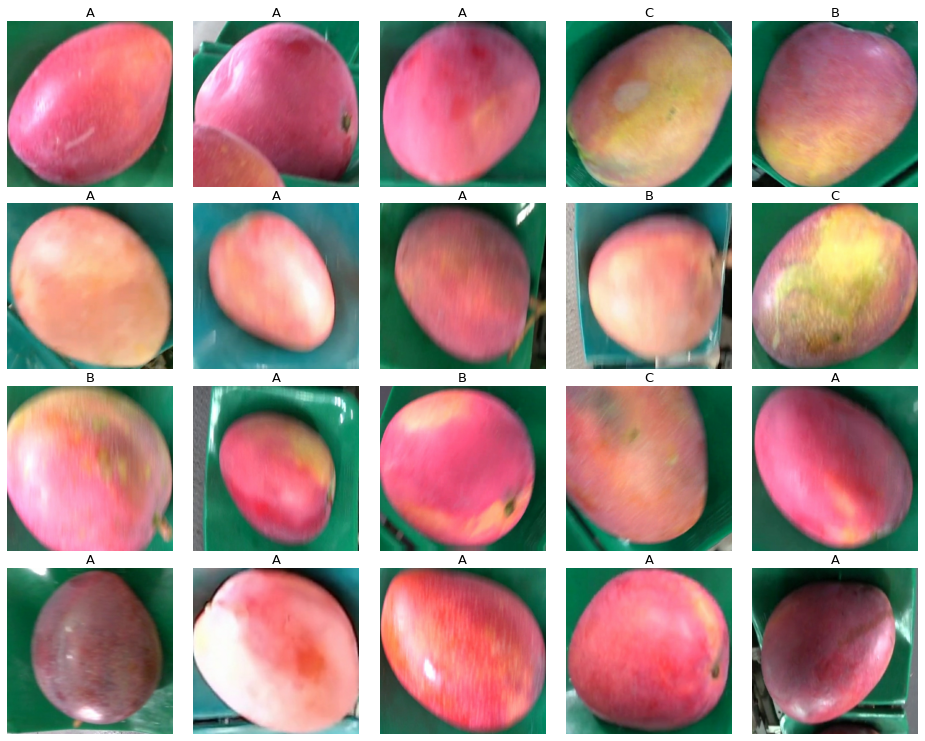

In [47]:
#view batch from train
display_batch_of_images(next(train_batch))
#you can run this cell again and it will load a new batch

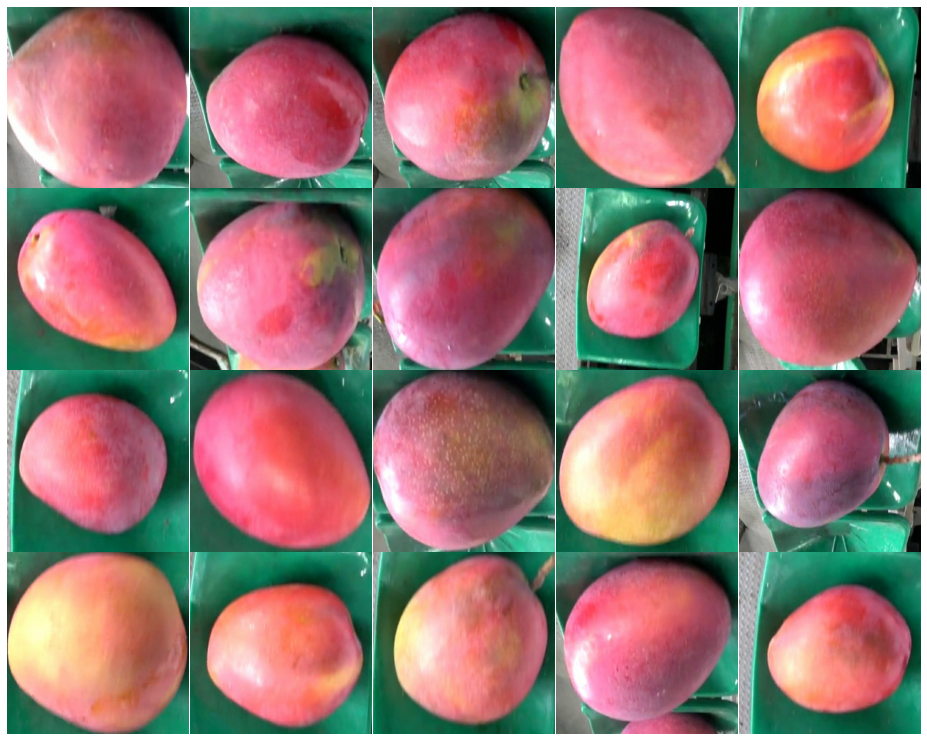

In [48]:
#view batch from test
display_batch_of_images(next(test_batch))
#you can run this cell again and it will load a new batch

## 八、資料擴增

In [49]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IPIXEL
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3]),label

In [50]:
#need to one hot encode images so we can blend their labels like above
def onehot(image,label):
    return image,tf.one_hot(label,len(CLASSES))

In [51]:
def mixup(image, label, PROBABILITY = 1.0):
    DIM = IPIXEL
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0

        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)

        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],len(CLASSES))
            lab2 = tf.one_hot(label[k],len(CLASSES))
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)

    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,len(CLASSES)))
    return image2,label2

In [52]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IPIXEL
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):

        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)

        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)

        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)

        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)

        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],len(CLASSES))
            lab2 = tf.one_hot(label[k],len(CLASSES))
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
        
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,len(CLASSES)))
    return image2,label2

In [53]:
#create function to apply both cutmix and mixup
def mixup_and_cutmix(image,label):
    DIM = IPIXEL
    
    #define how often we want to do activate cutmix or mixup
    SWITCH = 1/2
    
    #define how often we want cutmix or mixup to activate when switch is active
    CUTMIX_PROB = 2/3
    MIXUP_PROB = 2/3
    
    #apply cutmix and mixup
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    
    for j in range(BATCH_SIZE):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
        
    #must explicitly reshape so TPU complier knows output shape
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,len(CLASSES)))
    return image4,label4

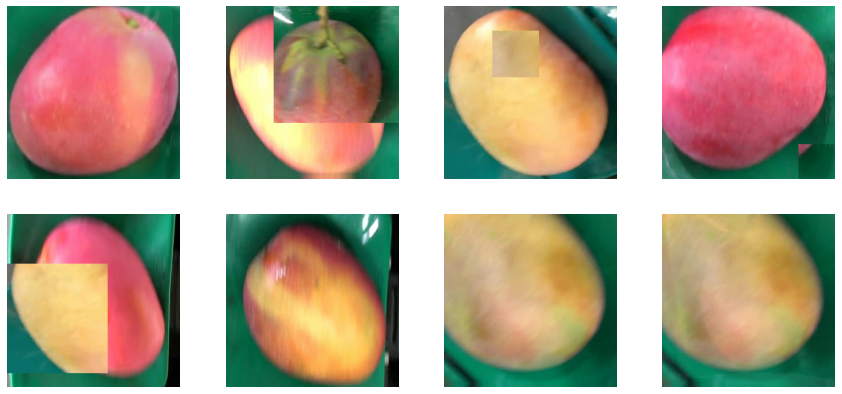

In [54]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_train_ds(files_train, repeat=True, shuffle=True, labeled=True, tta_aug=False, 
                            cutmix_aug=True, dim=IPIXEL, batch_size=BATCH_SIZE)

for (img,label) in all_elements:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

## 八、新建模型

In [55]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim,dim,3))
    
    if WEIGHTS_IMAGENET:
        base = EFNS[ef](input_shape=(dim,dim,3),weights='imagenet',include_top=False)
    else:
        base = EFNS[ef](input_shape=(dim,dim,3),weights='noisy-student',include_top=False)
        
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    if len(CLASSES) > 2:
        x = tf.keras.layers.Dense(len(CLASSES),activation='softmax')(x)
    else:
        x = tf.keras.layers.Dense(len(CLASSES),activation='sigmoid')(x)
        
    model = tf.keras.Model(inputs=inp,outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.trainable = True

    if len(CLASSES) > 2:
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
        model.compile(optimizer=opt,loss=loss,metrics=['categorical_accuracy'])
    else:
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
        model.compile(optimizer=opt,loss=loss,metrics=['auc'])
        
    return model

## 九、訓練行程表

In [56]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.00001
    lr_max     = 0.00005 * REPLICAS * batch_size
    lr_min     = 0.00001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lr_schedule(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)
    
    return lr_callback

In [57]:
if len(CLASSES) > 2:
    #define function to visualize learning curves
    def plot_learning_curves(history): 
        fig, ax = plt.subplots(1, 2, figsize = (20, 10))

        #plot accuracies
        for i in range(0, 3):
            ax[0].plot(history.history['categorical_accuracy'], color = 'C0')
            ax[0].plot(history.history['val_categorical_accuracy'], color = 'C1')

        #plot losses
        for i in range(0, 3):
            ax[1].plot(history.history['loss'], color = 'C0')
            ax[1].plot(history.history['val_loss'], color = 'C1')

        #fix legend
        ax[0].legend(['train', 'validation'], loc = 'upper left')
        ax[1].legend(['train', 'validation'], loc = 'upper right')

        #set master titles
        fig.suptitle("Model Performance", fontsize=14)

        #label axis
        for i in range(0,2):
            ax[0].set_ylabel('Accuracy')
            ax[0].set_xlabel('Epoch')
            ax[1].set_ylabel('Loss')
            ax[1].set_xlabel('Epoch')

        return plt.show()

## 十、訓練模型

In [58]:
skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []
preds = np.zeros((count_data_items(files_test),1))

models = []
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
          (IPIXEL,EFF_NETS[fold],BATCH_SIZE*REPLICAS))
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    if not LOCAL:
        files_train = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
    else:
        files_train = tf.io.gfile.glob([TRAIN_GCS_PATH + 'train%.2i*.tfrec'%x for x in idxT])
        
    np.random.shuffle(files_train); print('#'*25)
    
    if not LOCAL:
        files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
        files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    else: 
        files_valid = tf.io.gfile.glob([TRAIN_GCS_PATH + 'train%.2i*.tfrec'%x for x in idxV])
        files_test = np.sort(np.array(tf.io.gfile.glob(TEST_GCS_PATH + 'test*.tfrec')))
    
    print('train data count : '+str(count_data_items(files_train)))
    print('valid data count : '+str(count_data_items(files_valid)))
    print('test data count : '+str(count_data_items(files_test)))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=IPIXEL,ef=EFF_NETS[fold])
        
    if fold == 0:
        model.summary()
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')
    
    # TRAIN
    print('Training...')
    history = model.fit(
        get_train_ds(files_train, repeat=True, shuffle=True, labeled=True, tta_aug=False, 
                                cutmix_aug=True, dim=IPIXEL, batch_size=BATCH_SIZE), 
        epochs=EPOCHS[fold], 
        callbacks = [sv,get_lr_callback(BATCH_SIZE)], 
        steps_per_epoch=count_data_items(files_train)/BATCH_SIZE//REPLICAS, 
        validation_data=get_val_ds(files_valid, shuffle=True, labeled=False, dim=IPIXEL, batch_size=BATCH_SIZE),
        verbose=VERBOSE
    )
        
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)
      
    if len(CLASSES) > 2:
        models.append(model)
        plot_learning_curves(history)
    else:
        # PREDICT OOF USING TTA
        print('Predicting OOF with TTA...')
        ds_valid = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                repeat=True,shuffle=False,dim=IMAGE_SIZE[fold],batch_size=BATCH_SIZE*4)
        ct_valid = count_data_items(files_valid); STEPS = TTA * ct_valid/BATCH_SIZE/4/REPLICAS
        pred = model.predict(ds_valid,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
        oof_pred.append( np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )
        #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMAGE_SIZE[fold]),verbose=1))

        # GET OOF TARGETS AND NAMES
        ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=IMAGE_SIZE[fold],
                labeled=True, return_image_names=True)
        oof_tar.append( np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
        oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
        ds = get_dataset(files_valid, augment=False, repeat=False, dim=IMAGE_SIZE[fold],
                    labeled=False, return_image_names=True)
        oof_names.append( np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

        # PREDICT TEST USING TTA
        print('Predicting Test with TTA...')
        ds_test = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
                repeat=True,shuffle=False,dim=IMAGE_SIZE[fold],batch_size=BATCH_SIZE*4)
        ct_test = count_data_items(files_test); STEPS = TTA * ct_test/BATCH_SIZE/4/REPLICAS
        pred = model.predict(ds_test,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]

        # REPORT RESULTS
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))

        # PLOT TRAINING
        if DISPLAY_PLOT:
            plt.figure(figsize=(15,5))
            plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
            plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
            x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
            xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
            plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
            plt.legend(loc=2)
            plt2 = plt.gca().twinx()
            plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
            plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
            x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
            plt.ylabel('Loss',size=14)
            plt.title('FOLD %i - Image Size %i, EfficientNet B%i, inc2019=%i, inc2018=%i'%
                    (fold+1,IMAGE_SIZE[fold],EFF_NETS[fold],INC2019[fold],INC2018[fold]),size=18)
            plt.legend(loc=3)
            plt.show()

#########################
#### FOLD 1
#### Image Size 512 with EfficientNet B1 and batch_size 64
#########################
train data count : 36000
valid data count : 9000
test data count : 7000
27017216/27010080 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnet-b1 (Model)      (None, 16, 16, 1280)      6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 6,579,075
Trainable params: 6,517,027
Non-trainable params: 62,048
__________________________________________________

KeyboardInterrupt: 

## 十一、計算 OOF AUC

In [ ]:
if len(CLASSES) <= 2:
    # COMPUTE OVERALL OOF AUC
    oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
    names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
    auc = roc_auc_score(true,oof)
    print('Overall OOF AUC with TTA = %.3f'%auc)

    # SAVE OOF TO DISK
    df_oof = pd.DataFrame(dict(
        image_name = names, target=true, pred = oof, fold=folds))
    df_oof.to_csv('oof.csv',index=False)
    df_oof.head()

## 十二、Test Time Augmentation

In [ ]:
if len(CLASSES) > 2:
    def get_test_dataset(filenames, shuffle = False, repeat = True, labeled = False, tta_aug = True, return_image_names = True):

        ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        ds = ds.cache()

        if repeat:
            ds = ds.repeat()

        if shuffle: 
            ds = ds.shuffle(1024*8)
            opt = tf.data.Options()
            opt.experimental_deterministic = False
            ds = ds.with_options(opt)

        if labeled: 
            ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
        else:
            ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                        num_parallel_calls=AUTO)

        if tta_aug:
            ds = ds.map(data_augment, num_parallel_calls = AUTO)
            ds = ds.map(transform, num_parallel_calls=AUTO)

        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(AUTO)

        return ds

In [ ]:
if len(CLASSES) > 2:
    def average_tta_preds(tta_preds):
        average_preds = np.zeros((ct_test, len(CLASSES)))
        for fold in range(FOLDS):
            average_preds += tta_preds[(fold)*ct_test:(fold + 1)*ct_test] / FOLDS
        return average_preds

In [ ]:
if len(CLASSES) > 2:
    #since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_ds = get_test_dataset(TEST_FILENAMES, tta_aug = True, labeled = False,
                               repeat = True, return_image_names = True)
    test_images_ds = test_ds.map(lambda image, idnum: image)

    #set up TTA
    ct_test = count_data_items(TEST_FILENAMES)
    STEPS = TTA * ct_test/BATCH_SIZE

    #predict  
    print('Getting TTA predictions...')
    pred0 = models[0].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
    pred1 = models[1].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
    pred2 = models[2].predict(test_images_ds,steps = STEPS,verbose = 2)[:TTA*ct_test,] 
    print('')

    #get averages of each augmentation
    print('Averaging TTA predictions...')
    average_pred0 = average_tta_preds(pred0)
    average_pred1 = average_tta_preds(pred1)
    average_pred2 = average_tta_preds(pred1)
    print('')

    #merge together and average
    print('Merging predictions from models...')
    final_preds = np.zeros((ct_test, len(CLASSES)))
    final_preds += average_pred0
    final_preds += average_pred1
    final_preds += average_pred2

    #and take argmax to get in label form
    final_preds = np.argmax(final_preds, axis = 1)

    #lastly, get test ids for submission
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    print('Done')

## 十二、後期過程
有多種方法可以根據資訊修改預測值，以增加CV和LB。 可以在OOF上進行實驗

## 十三、提交

In [ ]:
if len(CLASSES) <= 2:
    ds = get_dataset(files_test, augment=False, repeat=False, dim=IMAGE_SIZE[fold],
                     labeled=False, return_image_names=True)

    image_names = np.array([img_name.numpy().decode("utf-8") 
                            for img, img_name in iter(ds.unbatch())])

In [ ]:
if len(CLASSES) > 2:
    #create submission dataframe
    submission = pd.DataFrame()
    submission['id'] = test_ids
    submission['label'] = final_preds
    print(submission.shape)
    submission.head(10)
else:
    submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
    submission = submission.sort_values('image_name') 
    submission.to_csv('submission.csv', index=False)
    submission.head()

In [ ]:
if len(CLASSES) > 2:
    #submit to disk
    submission.to_csv('submission.csv', index = False)
    print('Submission saved')
else:
    plt.hist(submission.target,bins=100)
    plt.show()